# Exploratory data analysis

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import pyLDAvis.gensim
import pyLDAvis
import gensim.corpora as corpora
from pprint import pprint
import gensim
from matplotlib.ticker import MaxNLocator
import re
from itertools import combinations
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from gensim.models.coherencemodel import CoherenceModel
# !pip install python-louvain
import community
import plotly.graph_objs as go
import plotly.express as px
from sklearn import preprocessing
from plotly.offline import download_plotlyjs, iplot, plot

import warnings
warnings.filterwarnings('ignore')

## Load the data

Lists that have been stored in CSV aren't automatically parsed by `pandas`. Thus this small function converts a string in the form `'{'banana', 'orange', 'tangerine'}'` in a Python list containing the same elements

In [2]:
def string_to_list(column):
    return [element.strip(" ") for element in column.strip("{}").replace("'", "").split(", ")]


def combine_fyp(hashtag):
    if re.search(r"(^fy)|(^for)|(^4u)", hashtag, flags=re.IGNORECASE):
        return "fyp"
    else:
        return hashtag


def clean_hashtag_list(hashtag_list):
    return sorted(list(set([combine_fyp(hashtag) for hashtag in hashtag_list])))

Simply use `read_csv` to import the data. We ignore the first column since we do not need these repeating ids. We can then apply our `string_to_list` function to the list of hashtags

In [3]:
tiktoks = pd.read_csv("./data/tiktoks_500.csv", usecols=range(1,8), parse_dates=["date"])
tiktoks.hashtags = tiktoks.hashtags.apply(string_to_list)
tiktoks.hashtags = tiktoks.hashtags.apply(clean_hashtag_list)
tiktoks.head(5)

,video_id,hashtags,date,user_id,n_likes,n_comments,n_shared
0,-4937456930930190897,"[aussie, biden2020, bidenharris2020, straya]",2020-11-07 01:51:07,-9074424973670462894,8300000,82700,238100
1,2837885220496618646,"[biden, biden2020, election2020, fyp, fürdich,...",2020-11-06 18:11:03,7802184149743201610,7200000,154800,536900
2,-7616690630605139661,"[biden2020, fyp]",2020-10-19 18:41:40,8599333060831776201,5000000,104800,400500
3,-1485617807006866345,"[biden2020, fyp, parati, repost, trump, trump2...",2020-06-16 22:41:10,-2163225678390988754,5000000,136100,356100
4,8847244246175840872,[biden2020],2020-10-31 23:04:55,8834409548135308984,4600000,68700,218100


## Visualitions

We first create a list containing all the hashtags we used to collect the data.

Then we create the DataFrame `tiktoks_exploded` that contains one entry for each hashtags. This means that if a row had hashtags `['Biden2020', 'bidenharris2020']`, the exploded version will transform it in two distinct rows, each with a single hashtag

In [4]:
queried_hashtags = ["biden2020", "trump2020", "biden", "trump", "election2020", "2020election", "donaldtrump", "joebiden", "maga", "trumpout",
                    "democrat", "republican", "trumpvsbiden", "bidenvstrump", "voteblue", "votered"]
tiktoks_exploded = tiktoks.explode("hashtags")

Display the distribution of publications of each of the queried hashtags. Each bin represents a period of 10 days.

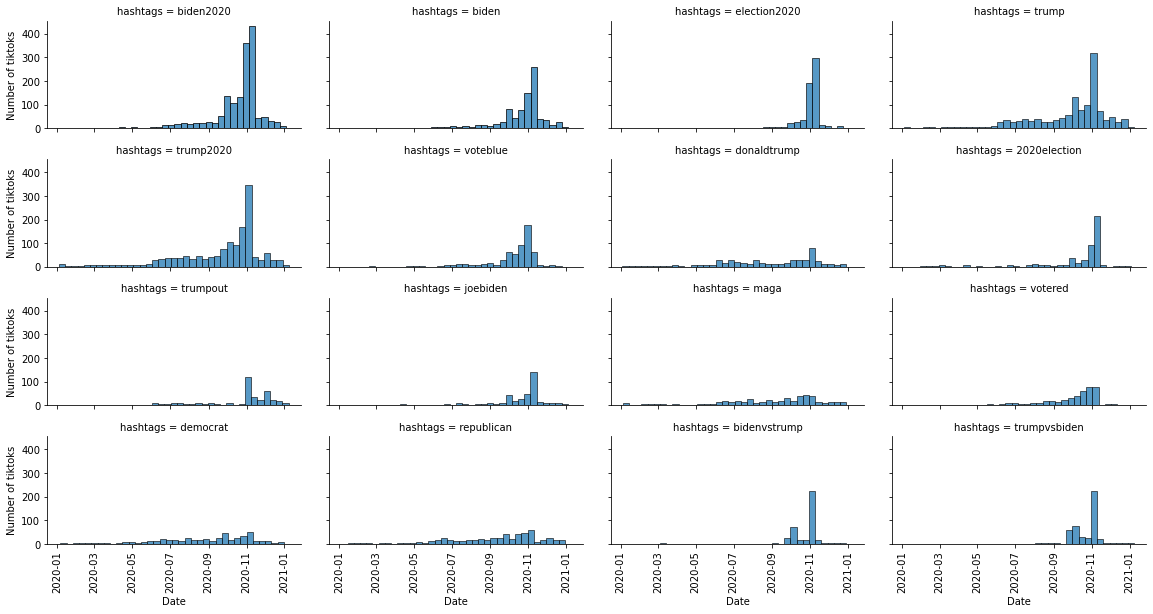

In [5]:
g = sns.FacetGrid(tiktoks_exploded.query("hashtags in @queried_hashtags"), col="hashtags", col_wrap = 4, sharex = True, sharey=True, height = 2, aspect=2)
g.map_dataframe(sns.histplot, x="date", binwidth=10)
g.set_axis_labels("Date", "Number of tiktoks")
g.set_xticklabels(rotation=90)

Display the top 20 most used hashtags in our dataset

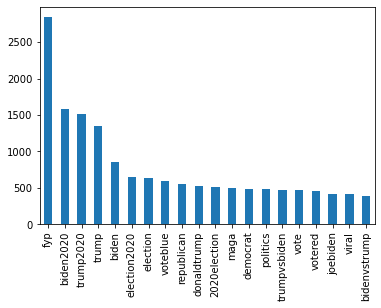

In [6]:
top_20 = tiktoks_exploded.hashtags.value_counts()[:20].plot(kind="bar")

# Looking at the distribution of hashtags overtime

Creating a new column to store only date of the video (to groupby videos based on date)

In [7]:
tiktoks_exploded['only_date'] = pd.to_datetime(tiktoks_exploded['date']).dt.date.astype(dtype='datetime64[ms]')

Grouping the tiktoks based on date and then hastags to the hashtag count perday

In [8]:
tiktoks_hash_grouped = tiktoks_exploded.groupby(["only_date","hashtags"]).size().to_frame(name = 'count').reset_index()
tiktoks_hash_grouped

,only_date,hashtags,count
0,2020-01-03,2020,1
1,2020-01-03,america,1
2,2020-01-03,arianagrande,1
3,2020-01-03,donaldtrump,1
4,2020-01-03,fyp,2
...,...,...,...
18351,2020-12-31,viratkohli,1
18352,2020-12-31,whatilearned,1
18353,2020-12-31,whatwouldyoudo,1
18354,2020-12-31,wordsofwisdom,1


As there are many hashtags that have occured very less frequent of time compared to others, we remove all the hashtags that have occured less than specified number of times

In [9]:
minimum_occurances = 500
hashtag_value_counts = tiktoks_exploded["hashtags"].value_counts()
hash_list = hashtag_value_counts[hashtag_value_counts > minimum_occurances].index.tolist()

# hash_list contains the hashtags that have been used more than *minimum_occurances* number of times

In [10]:
tiktok_ht_min_occ = tiktoks_hash_grouped[tiktoks_hash_grouped['hashtags'].isin(hash_list)]

Creating a new dataframe with each hashtag as column and value as the count of hashtag occurance on that day

In [11]:
perday_hashtag_count = tiktok_ht_min_occ.pivot_table(values='count', index="only_date", columns='hashtags', aggfunc='first', fill_value=0)

In [12]:
GB=perday_hashtag_count.groupby([(perday_hashtag_count.index.year),(perday_hashtag_count.index.month)]).sum()
perday_hashtag_count_norm = GB.div(GB.sum(axis=1), axis=0)

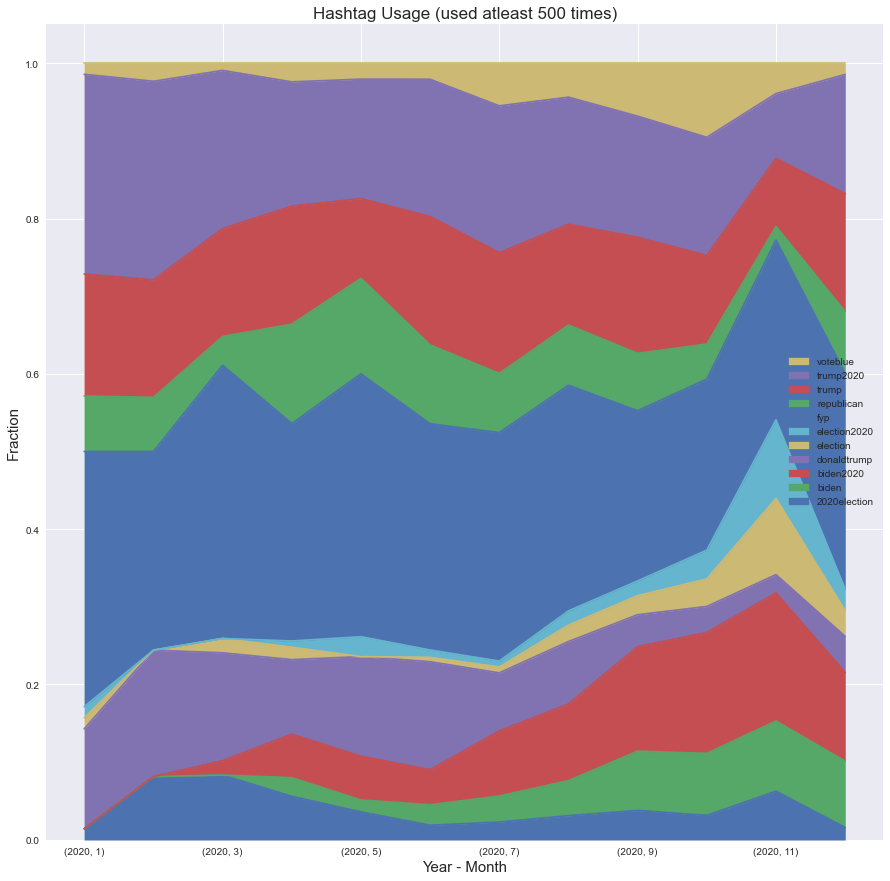

In [13]:
plt.style.use('seaborn')
perday_hashtag_count_norm.plot.area(figsize=(15, 15))
plt.xlabel('Year - Month', fontsize=15)
plt.ylabel('Fraction', fontsize=15)
plt.title('Hashtag Usage (used atleast {} times)'.format(minimum_occurances), fontsize=17)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
ax.legend(handles, labels)
plt.show()

Similar plot using Seaborn

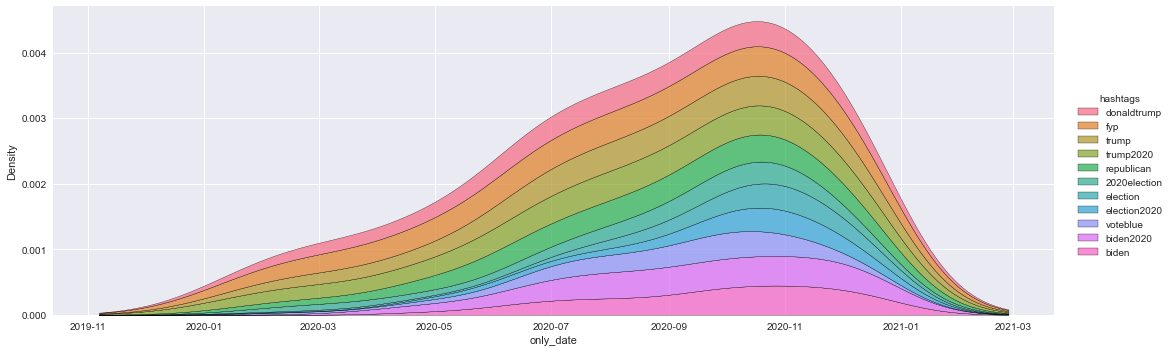

In [14]:
sns.displot(tiktok_ht_min_occ, x="only_date", hue="hashtags", kind="kde", multiple="stack", aspect = 3)

##### Using the area occupied by each hashtag in the plot we can how has the usage shifted over time

1. We should make small plots dividing over time to analyse easily

# Matching TikToks with events

Top 10 days when people posted tiktoks about the elections:

In [15]:
tiktoks["only_date"] = pd.to_datetime(tiktoks['date']).dt.date.astype(dtype='datetime64[ms]')
tiktoks.only_date.value_counts()[:10]

2020-11-04    395
2020-11-07    278
2020-11-05    260
2020-11-03    243
2020-11-06    201
2020-09-30    145
2020-11-08    127
2020-11-02    103
2020-10-27     58
2020-10-23     58
Name: only_date, dtype: int64

* Nov. 2-8 : Election Day was on the 3rd. With all the fuss about the count delays, recounts, fraud claims, etc... the hype lived up until the eighth
* Sep. 30 : The infamous first debate between Biden and Trump that ended up being a shitshow
* Oct. 27 : The Senate confirms Amy Coney Barrett to the supreme court one week before the election lol
* Oct. 23 : Second debate between Biden and Trump

# Cooccurances

Creates a co-occurance matrix using pandas

In [16]:
lst = list(tiktoks.hashtags)
u = (pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='')
       .groupby(level=0, axis=1)
       .sum())

v = u.T.dot(u)
v.values[(np.r_[:len(v)], ) * 2] = 0

In [17]:
def plot_co_occurance_matrix(matrix, threshold, figsize):
    fig, axes = plt.subplots(figsize=figsize)
    top_100_indices = matrix[matrix.sum(axis=1) > threshold].index
    print(len(top_100_indices))
    sns.heatmap(matrix[matrix.sum(axis=1) > threshold][list(top_100_indices)], cmap="rocket_r")

We plot the co_occurance matrix only using the hashtags with more than 600 occurances

* We observe that (biden, trump) and (biden2020, trump2020) have the most co-occurances. Could it suggest that most TikToks are about the elections in general and not rooting for a particular party ?
* Biden appears a lot with `fyp`, whereas Trump barely does. Does it show that Biden supporters are the more experienced TikTok's user and know that platform better ? Which would also show Biden supporters are the younger generation.
* Without surprise, (Trump, Trump2020) and (Biden, Biden2020) appear often together.
* blm doesn't seem more corrolated to biden than trump

## !"fyp" is not visible in the heatmap, not sure what is happening as it is present in top_100_indices.

49


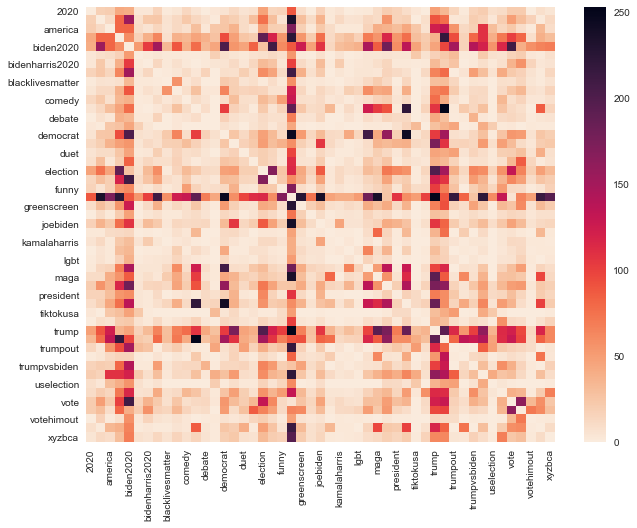

In [18]:
plot_co_occurance_matrix(v, 600, (10.5,8))

Let us now try to get a 2D embedding of each word from this co-occurance matrix by using the Truncated SVD from SkLearn

In [19]:
tsvd = TruncatedSVD(n_components=2)
v_transformed = tsvd.fit_transform(v)

We only keep the embeddings of the hashtags with more than 600 occurances

In [20]:
top_600_indices = list(v[v.sum(axis=1) > 600].index)
v_transformed_reduced = v_transformed[v.sum(axis=1) > 600]

Plot the embeddings

In [21]:
def plot_embeddings(words, vec, figsize):
    fig, axes = plt.subplots(figsize=(10,10))
    for i,word in enumerate(words):
        x = vec[i][0]
        y = vec[i][1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y+0.01, word, fontsize=9)
    plt.show()

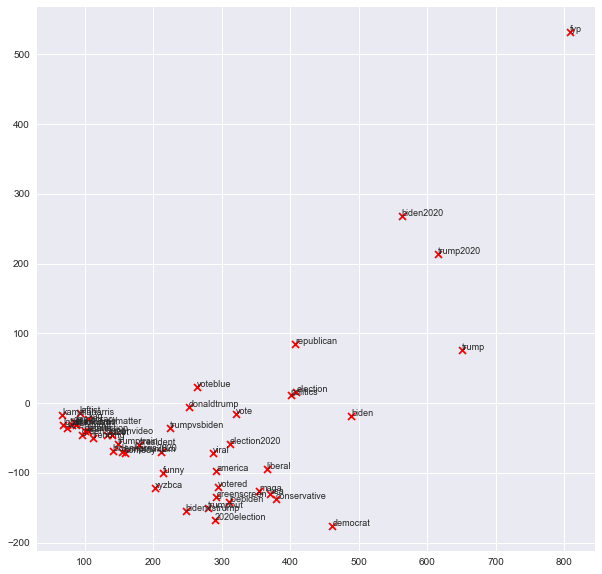

In [22]:
plot_embeddings(top_600_indices, v_transformed_reduced, (10,10))

**In the next cell, the parameter `vector_size` is just `size` in older version of gensim** 

In [23]:
model = Word2Vec(sentences=tiktoks.hashtags, size=2, window=3, min_count=1, workers=4)
vecs = []
for hashtag in top_600_indices:
    vecs.append(model.wv[hashtag])

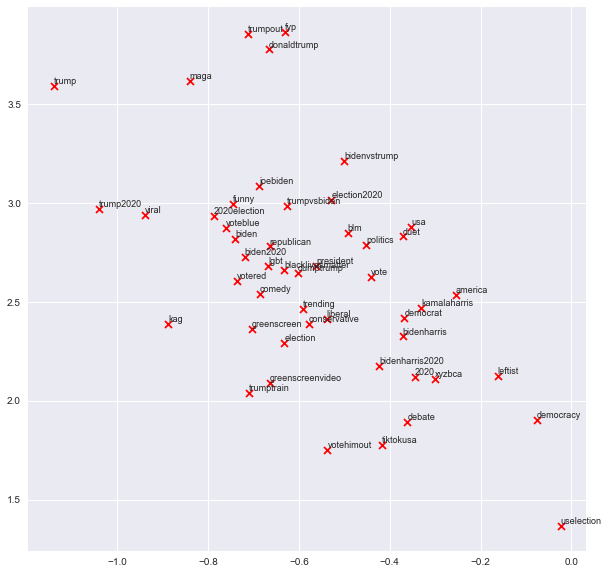

In [24]:
plot_embeddings(top_600_indices, vecs, (10,10))

Let's try to plot the heatmap of the word embeddings using the cosine similarity

In [25]:
vec_length = 10
model = Word2Vec(sentences=tiktoks.hashtags, size=vec_length, window=2, min_count=1, workers=4)
vecs = np.empty((len(top_600_indices),vec_length))
for i in range(len(top_600_indices)):
    vecs[i] = model.wv[top_600_indices[i]]

## !The color map in the heatmap below is not intutive, (it has darkcolor for lower value and light color for highvalue). So we could change this

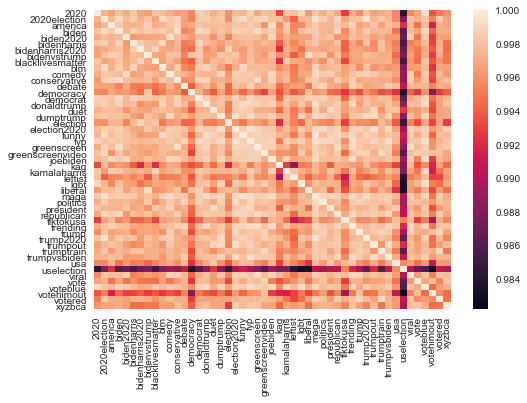

In [26]:
ax = sns.heatmap(cosine_similarity(vecs), xticklabels=top_600_indices, yticklabels=top_600_indices)

# User Clustering using hashtags

Create a user profile based on hashtags i.e create a bag of hashtag vector.

First, we select the hashtags with minimum occurances

# Video Clustering using hashtags

## Word Cloud of Hashtags

In [27]:
long_string = ','.join((list([a for b in tiktoks.hashtags.tolist() for a in b])))

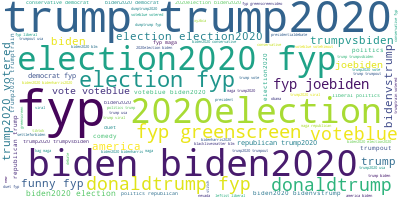

In [28]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Word Cloud of Hashtags in USA map style.

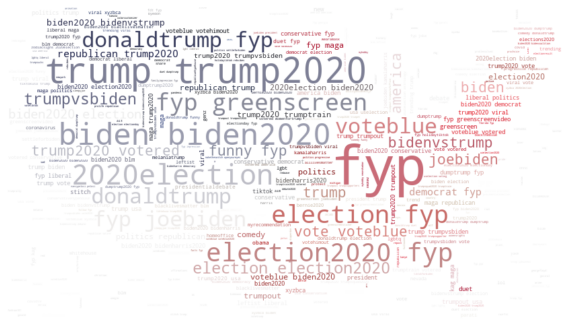

In [29]:
mask = np.array(Image.open("img/us.jpg"))
wordcloud_usa = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(long_string)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

## Topic Modelling of videos

In [30]:
data_words = tiktoks.hashtags.values.tolist()

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

We shall remove those hashtags that have frequency less than the minimum frequency

In [31]:
ids = [id2word.token2id[hash_list[i]] for i in range(len(hash_list))]
id2word.filter_tokens(bad_ids=ids)

In [32]:
corpus = [id2word.doc2bow(text) for text in data_words]

In [33]:
scores = pd.DataFrame(columns=["c_v", "u_mass"])


for n_topics in range(2, 20, 1):
    print("Number of topics : ", n_topics)
    model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n_topics)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_model_lda_u_mass = CoherenceModel(model=model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_lda_u_mass = coherence_model_lda_u_mass.get_coherence() 
    print('Coherence Score c_v: ', coherence_lda)
    print('Coherence Score u_mass: ', coherence_lda_u_mass)
    scores.loc[n_topics] = {'c_v' : coherence_lda, 'u_mass': coherence_lda_u_mass}

Number of topics :  2
Coherence Score c_v:  0.23670015478763612
Coherence Score u_mass:  -3.6364629042717764
Number of topics :  3
Coherence Score c_v:  0.2165669126725389
Coherence Score u_mass:  -4.039949509636092
Number of topics :  4
Coherence Score c_v:  0.23282967820955422
Coherence Score u_mass:  -4.253152857391753
Number of topics :  5
Coherence Score c_v:  0.2348340470336207
Coherence Score u_mass:  -4.339576922920894
Number of topics :  6
Coherence Score c_v:  0.26966634043338467
Coherence Score u_mass:  -4.935736780867045
Number of topics :  7
Coherence Score c_v:  0.24119684202273692
Coherence Score u_mass:  -4.418592764605726
Number of topics :  8
Coherence Score c_v:  0.24547881211139663
Coherence Score u_mass:  -4.50936745472926
Number of topics :  9
Coherence Score c_v:  0.23184926135674308
Coherence Score u_mass:  -4.347559397066433
Number of topics :  10
Coherence Score c_v:  0.2478364271567624
Coherence Score u_mass:  -4.642061239193714
Number of topics :  11
Coheren

In [34]:
copy_score = scores.copy()
copy_score = (copy_score-copy_score.mean())/copy_score.std()

Text(0, 0.5, 'Coherence Score (C_v)')

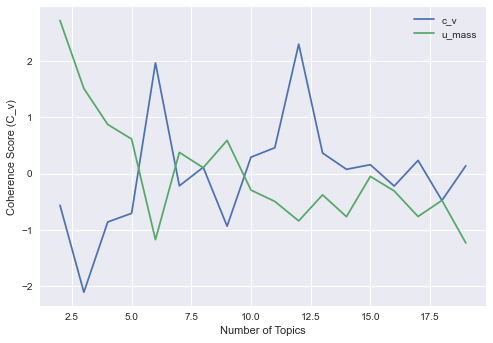

In [35]:
ax = copy_score.reset_index().plot(x = 'index', y = ['c_v', 'u_mass'], sharey=False)
ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence Score (C_v)")

In [36]:
# number of topics
num_topics = 4

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"greenscreen" + 0.021*"viral" + 0.020*"america" + 0.016*"comedy" + '
  '0.015*"trumpvsbiden" + 0.012*"democrat" + 0.011*"joebiden" + '
  '0.010*"bidenvstrump" + 0.010*"news" + 0.009*"votered"'),
 (1,
  '0.042*"vote" + 0.027*"politics" + 0.022*"usa" + 0.022*"democrat" + '
  '0.022*"joebiden" + 0.018*"trumpout" + 0.014*"votered" + 0.013*"viral" + '
  '0.012*"bidenvstrump" + 0.012*"xyzbca"'),
 (2,
  '0.034*"maga" + 0.026*"trumpvsbiden" + 0.025*"conservative" + '
  '0.024*"votered" + 0.022*"bidenvstrump" + 0.015*"politics" + 0.014*"viral" + '
  '0.013*"funny" + 0.013*"joebiden" + 0.013*"liberal"'),
 (3,
  '0.022*"duet" + 0.020*"democrat" + 0.019*"blm" + 0.019*"liberal" + '
  '0.018*"trumpout" + 0.017*"trumpvsbiden" + 0.016*"maga" + '
  '0.016*"greenscreen" + 0.013*"conservative" + 0.012*"votered"')]


In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.054511  0.062463       1        1  33.894045
2     -0.058433 -0.037832       2        1  25.837601
3     -0.050274  0.040975       3        1  22.197430
0      0.054196 -0.065606       4        1  18.070924, topic_info=                 Term        Freq       Total Category  logprob  loglift
25               vote  392.000000  392.000000  Default  30.0000  30.0000
351              duet  160.000000  160.000000  Default  29.0000  29.0000
166           america  204.000000  204.000000  Default  28.0000  28.0000
53               maga  391.000000  391.000000  Default  27.0000  27.0000
18        greenscreen  276.000000  276.000000  Default  26.0000  26.0000
..                ...         ...         ...      ...      ...      ...
32                usa   22.824291  259.670922   Topic4  -5.2228  -0.7207
149          trending   15.034157   88.219849   Topic4  -5.6403  -0.0586
73   blacklivesmatter   14.652459   98.234014   Topic4  -5.6660  -0.1919
93       conservative   16.431240  288.978525   Topic4  -5.5514  -1.1563
25               vote   15.468907  392.958127   Topic4  -5.6118  -1.5240

[318 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
61        1  0.393229        2020
61        2  0.239357        2020
61        3  0.059839        2020
61        4  0.307745        2020
974       1  0.278628  4moreyears
...     ...       ...         ...
76        2  0.122090      xyzbca
76        3  0.273248      xyzbca
76        4  0.040697      xyzbca
1193      1  0.871139   yahoonews
1193      2  0.134021   yahoonews

[510 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

Trying to reproduce https://towardsdatascience.com/how-to-cluster-similar-sentences-using-tf-idf-and-graph-partitioning-in-python-5fb70627a4e0

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
data_words_wo_fyp = [[h for h in k  if h!='fyp'] for k in data_words]

In [40]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0)
tfidf = tf.fit_transform([' '.join(hs) for hs in data_words_wo_fyp])

In [41]:
from sklearn.metrics.pairwise import linear_kernel
cs = linear_kernel(tfidf, tfidf)

In [44]:
import numpy as np
from tqdm import tnrange


def find_best_n_topics(n_max):
    best_mod = 0
    best_part = 0
    best_g = 0
    best_top_sentences = []
    
    for i in tnrange(5, n_max, 2):
        top_n_sentences = []

        no_dups = np.array([' '.join(hs) for hs in data_words_wo_fyp])
        i = 0
        top_frame = []
        for c, z in zip(cs, tnrange(len(cs))):
            # Create vector of titles
            start_name = pd.Series([no_dups[i]]*i) 
            # Index of top 15 similar titles
            ix_top_n = np.argsort(-c)[0:i]
            cos_sim = pd.Series(c[ix_top_n])
            names = pd.Series(no_dups[ix_top_n])
            i +=1
            top_frame.append(pd.DataFrame([start_name, names, cos_sim]).transpose())
        print("yo")
        top_frame = pd.concat(top_frame)
        top_frame.columns = ['title1', 'title2', 'cos_sim']
        # Remove the similarities for the same sentences
        top_frame['is_same'] = [bool(i==j) for i, j in zip(top_frame['title1'], top_frame['title2'])]
        top_frame = top_frame[top_frame['is_same'] != True]

        top_n_sentences.append(top_frame)
        print("yo2")
        # We start by defining the structure of the graph
        top_frame = top_n_sentences[0] #TDS articles
        edges = list(zip(top_frame['title1'], top_frame['title2']))
        weighted_edges = list(zip(top_frame['title1'], top_frame['title2'], top_frame['cos_sim']))
        nodes = list(set(top_frame['title1']).union(set(top_frame['title2'])))

        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        G.add_weighted_edges_from(weighted_edges)
        print("yo3")
        partition = community.best_partition(G)
        modularity = community.modularity(partition, G)
        print("yo4")
        if (modularity > best_mod):
            best_mod = modularity
            best_part = partition
            best_g = G
            best_top_sentences = top_n_sentences
    return best_mod, best_part, best_g, best_top_sentences

In [ ]:
best_mod, best_part, best_g, best_top_sentences = find_best_n_topics(20)

Exception ignored in: <function tqdm.__del__ at 0x7fbc1ac34f70>
Traceback (most recent call last):
  File "/Users/elisamichelet/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py", line 1085, in __del__
    def __del__(self):
KeyboardInterrupt: 


In [113]:
# We start by defining the structure of the graph
top_frame = top_n_sentences[0] 
edges = list(zip(top_frame['title1'], top_frame['title2']))
weighted_edges = list(zip(top_frame['title1'], top_frame['title2'], top_frame['cos_sim']))
nodes = list(set(top_frame['title1']).union(set(top_frame['title2'])))

In [114]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
G.add_weighted_edges_from(weighted_edges)

In [115]:
partition = community.best_partition(G)
modularity = community.modularity(partition, G)

In [123]:
# aim : high modularity
print(modularity)

0.6464158086311315


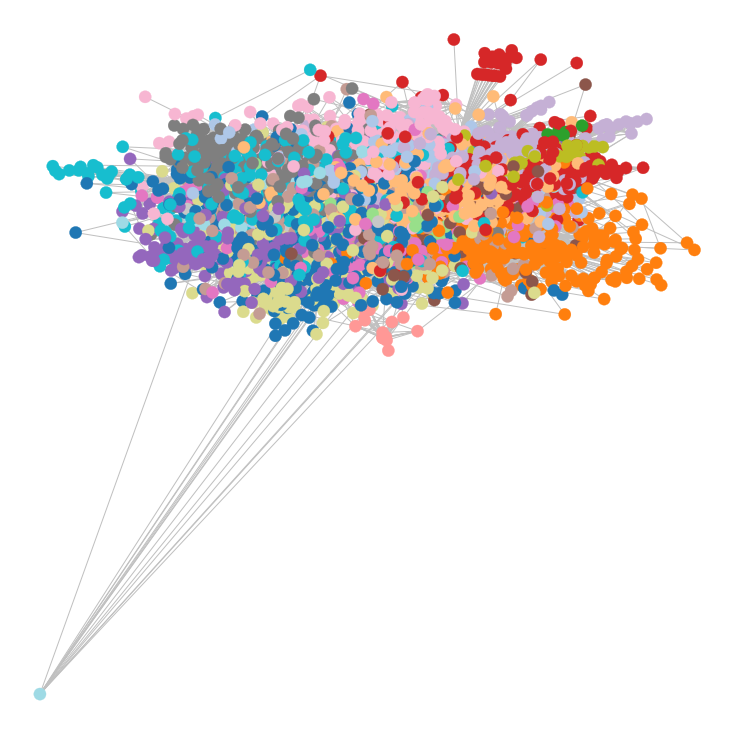

In [116]:
# Takes some time 

pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]
fig = plt.figure(figsize=(10,10))
nx.draw(G, pos, edge_color = ['silver']*len(G.edges()), cmap=plt.cm.tab20,
        node_color=community_id, node_size=150)

In [117]:
title, cluster = [], []
for i in partition.items():
    title.append(i[0])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']

In [118]:
frame_clust.groupby('Cluster').count()

,Title
Cluster,
0,247
1,332
2,180
3,262
4,495
5,14
6,50
7,435
8,17


In [119]:
def find_n_top_words(topic, n):

    frame_clust['Title'] = frame_clust.apply(lambda row: " " + row['Title'] , axis=1)
    wordstring = frame_clust[frame_clust['Cluster']==topic]['Title'].str.cat()
    wordlist = wordstring.split(' ')
    wordfreq = [wordlist.count(w) for w in wordlist]


    pairs = [p for p in set(zip(wordlist, wordfreq)) if p[0]!='']
    top_n_words = sorted(pairs, key=lambda tup: tup[1], reverse=True)[:n]
    top_n_words = [w[0] for w in top_n_words]
    long_string = ','.join(list(top_n_words))
    return long_string

In [120]:
topics = pd.DataFrame()

for i in range(21):
    topics = topics.append([find_n_top_words(i, 10)])

In [121]:
topic_names = ['election general - biden', 'both sides', 'republican', 'democrat', 'democrat - nancy pelosi',
              'election general', 'general', 'general', 'democrat', 'general', 'conservative talking about blm + lgbtq', 'conservative ++',
              'pro biden', 'pro trump ++', 'general', 'election day', 'jokes', 'debate', 'astrology', 'democracia', 'gay']

In [122]:
pd.set_option('display.max_colwidth', None)
topics.set_index([pd.Index(topic_names)])

,0
election general - biden,"trumpvsbiden,election2020,greenscreen,biden2020,viral,trump,dumptrump2020,vote,biden,election"
both sides,"biden2020,trump2020,trumpvsbiden,trump,election2020,politics,biden,greenscreen,voteblue,vote"
republican,"blm,blacklivesmatter,biden2020,trump2020,democrat,trump,maga,voteblue,lgbt,liberal"
democrat,"donaldtrump,trump,usa,funny,viral,america,comedy,trump2020,melaniatrump,president"
democrat - nancy pelosi,"democrat,republican,liberal,biden2020,trump2020,politics,conservative,trump,biden,maga"
election general,"blackconservative,maketheswitch,openyoureyes,republican,conservative,trump2020,democrat,maga,blacklivesmatter,blackrepublican"
general,"trump,politics,comedy,election,liberal,republican,progressive,biden,biden2020,satire"
general,"trump2020,votered,trump,republican,conservative,maga,biden2020,stitch,kag,politics"
democrat,"2020election,zodiacsigns,astrology,boo,biden2020,dayinmylife,welldone,wip,bbmas,voteblue2020"
general,"bidenvstrump,biden2020,biden,election,trump,trump2020,2020election,election2020,vote,greenscreen"


## Hashtag Analysis

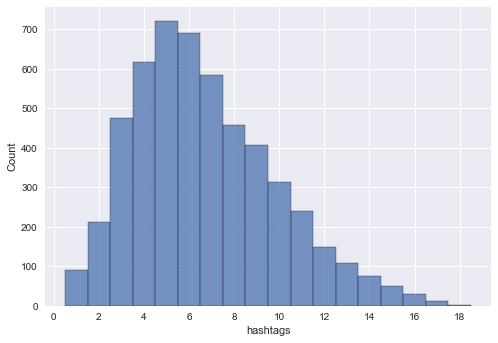

In [51]:
tiktoks_hashtag_count = tiktoks.hashtags.apply(lambda x: len(x))
ax = sns.histplot(tiktoks_hashtag_count, discrete=True)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

From the histogram above, we obtain an insight into the number of hashtags used per video. On average users use 5,6,7 hashtags per video and only few videos use more than 10 hashtags.

Next we build a graph of hashtags where each none of the craft represents a hashtag and an edge between two loads exist if the hashtags are mentioned together. We select hashtags that have appeared atleast 50 times. Additionally, we remove the `fyp` hashtag as it is used in almost all videos.

We define two functions to plot the network.

In [220]:
def plotGraph(node_df, G, sizing=50, node_size='adjacency_frequency',layout=nx.kamada_kawai_layout):

        back_col = '#ffffff'
        edge_col = '#ece8e8'
        
        """
        normalise all graph metrics
        """
        #subset graph metrics
        X = node_df[node_df.columns[2:5]]

        #get columns labels
        cols = node_df.columns[2:5]

        #instantiate instance of MinMaxScaler class
        min_max_scaler = preprocessing.MinMaxScaler()

        #transform graph metrics
        X_scaled = min_max_scaler.fit_transform(X)

        #create new dataframe of scaled metrics
        plot_df = pd.DataFrame(X_scaled)

        plot_df.columns=cols

        for i in plot_df.columns:
            plot_df[i] = plot_df[i].apply(lambda x: x*sizing)


        #extract graph x,y co-ordinates from G instance
        pos = layout(G)

        #add position of each node from G to 'pos' key
        for node in G.nodes:
            G.nodes[node]['pos'] = list(pos[node])



        stack = []

        index = 0

        #add edges to Plotly go.Scatter object
        for edge in G.edges:

            x0, y0 = G.nodes[edge[0]]['pos']

            x1, y1 = G.nodes[edge[1]]['pos']

            weight = 0.5

            trace = go.Scatter(x=tuple([x0, x1, None]), y=tuple([y0, y1, None]),
                               mode='lines',
                               line={'width': weight},
                               marker=dict(color=edge_col),
                               line_shape='spline',
                               opacity=1)

            #append edge traces
            stack.append(trace)

            index = index + 1

        #make a partly empty dictionary for the nodes
        marker = {'size':[],'line':dict(width=0.5,color=edge_col),'color':[]}


        #initialise a go.Scatter object for the nodes
        node_trace = go.Scatter(x=[], y=[], hovertext=[], text=[], mode='markers', textposition="bottom center",
                                hoverinfo="text", marker=marker)

        index = 0

        #add nodes to Plotly go.Scatter object
        for node in G.nodes():

            x, y = G.nodes[node]['pos']

            node_trace['x'] += tuple([x])

            node_trace['y'] += tuple([y])

            node_trace['text'] += tuple([node_df['hashtag'][index]])

            node_trace['marker']['color'] += tuple(list(node_df.community))

            node_trace['marker']['size'] += tuple([list(node_df.adjacency_frequency)[index]])

            index = index + 1

        #append node traces
        stack.append(node_trace)


        #set up axis for plot
        axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
                  zeroline=False,
                  showgrid=False,
                  showticklabels=False,
                  title=''
                  )

        #set up figure for plot
        figure = {
        "data": stack,
        "layout":
        go.Layout(title=str('Hashtag Network'),
                    font= dict(family='Arial',size=20),
                    width=1100,
                    height=1100,
                    autosize=False,
                    showlegend=False,
                    xaxis=axis,
                    yaxis=axis,
                    margin=dict(
                    l=40,
                    r=40,
                    b=85,
                    t=100,
                    pad=0,

            ),
            hovermode='closest',
            plot_bgcolor=back_col, #set background color
            )}

        #plot the figure
        iplot(figure)

        return

In [221]:
def plotCommunity(node_df,colorscale=False):

        #make copy of node dataframe
        df_temp = node_df.copy()

        #change community label to string (needed for plot)
        df_temp['community'] = df_temp['community'].map(lambda x: str(x))

        #conditionals for plot type
        if colorscale == False:

            fig = px.sunburst(df_temp, path=['community', 'hashtag'], values='adjacency_frequency',color='community',hover_name=None,
                          hover_data=None)
        else:
            fig = px.sunburst(df_temp, path=['community', 'hashtag'], values='adjacency_frequency',
                          color='betweeness_centrality', hover_data=None,
                          color_continuous_scale='blugrn',
                          color_continuous_midpoint=np.average(df_temp['betweeness_centrality'], weights=df_temp['betweeness_centrality']))

        #add margin to plot
        fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))

        #offline sunburst plot
        iplot(fig)

        return

In [289]:
minimum_occurances = 50
hashtag_value_counts = tiktoks_exploded["hashtags"].value_counts()
hash_list = hashtag_value_counts[hashtag_value_counts > minimum_occurances].index.tolist()
hash_list.remove("fyp")

In [290]:
hashtag_graph = nx.Graph()

for hashtag_list in data_words_wo_fyp:
    if len(hashtag_list) == 1:
        if (hashtag_list[0] in hash_list):
            hashtag_graph.add_node(hashtag_list[0])
    else:
        links = list(combinations(hashtag_list, 2))
        
        for ht1, ht2 in links:
            if (ht1 in hash_list) and (ht2 in hash_list):
                if not hashtag_graph.has_edge(ht1, ht2):
                    hashtag_graph.add_edge(ht1, ht2)

In [291]:
nodes_df = pd.DataFrame(hashtag_graph.nodes()).rename(columns={0:"hashtag"})

Source for below analysis: https://towardsdatascience.com/using-network-science-to-explore-hashtag-culture-on-instagram-1f7917078e0

First we calculate the adjacency value i.e. number of hashtags each hashtag is connected to. Then we compute the betweenness centrality each hashtag which is the number of these shortest paths that pass through the node in the graph. Next, we compute clustering coefficient which is measure of the degree to which nodes in a graph tend to cluster together. In this case, it is the fraction of possible triangles through that node that exist. 

Next, we identify the communities of hashtags in the network using `Clauset-Newman-Moore greedy modularity maximization` method. The algorithm begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists and then assign each hashtag a community.

In [292]:
# adjacency_frequency
hashtag_adjacencies = dict(hashtag_graph.adjacency())
nodes_df['adjacency_frequency'] = nodes_df['hashtag'].map(lambda x: len(hashtag_adjacencies[x]))

# betweeness_centrality
hashtag_betweeness = nx.betweenness_centrality(hashtag_graph)
nodes_df['betweeness_centrality'] = nodes_df['hashtag'].map(lambda x: hashtag_betweeness[x])

# clustering_coefficient
hashtag_clustering_coeff = nx.clustering(hashtag_graph)
nodes_df['clustering_coefficient'] = nodes_df['hashtag'].map(lambda x: hashtag_clustering_coeff[x])

# community
communities = greedy_modularity_communities(hashtag_graph)
communities_dict = {}

nodes_in_community = [list(i) for i in communities]

for i in nodes_in_community:
    communities_dict[nodes_in_community.index(i)] = i

def community_allocation(source_val):
    for k,v in communities_dict.items():
        if source_val in v:
            return k

nodes_df['community'] = nodes_df['hashtag'].map(lambda x: community_allocation(x))

Now, we plot the network and communities for analysis.

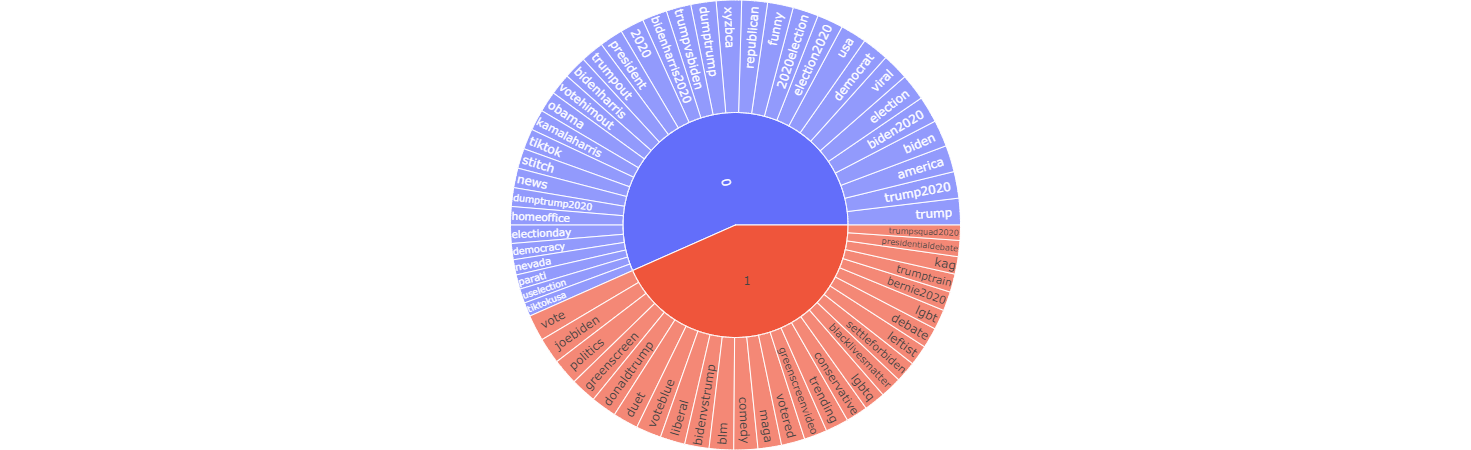

In [293]:
plotCommunity(nodes_df)

![communities](./img/plots/communities.png)

When we consider, hashtags that have appeared at least 50 times we find that there are two main communities. We can interpret these as seasonal and those used consistently. The first community that is in blue has the hashtags that were populat during the 2020 elections like trump/biden2020, uselections, 2020elections, bidenharris, kamalaharris, trumpout. Not only these but due to the pandemic during that season we see homeoffice. In the second community that is in red, we see those that have themes or persona attached to them and those that are used generally in making tiktoks. 

##### I cannot distinguish between these two. 😂 May be we can discuss together.

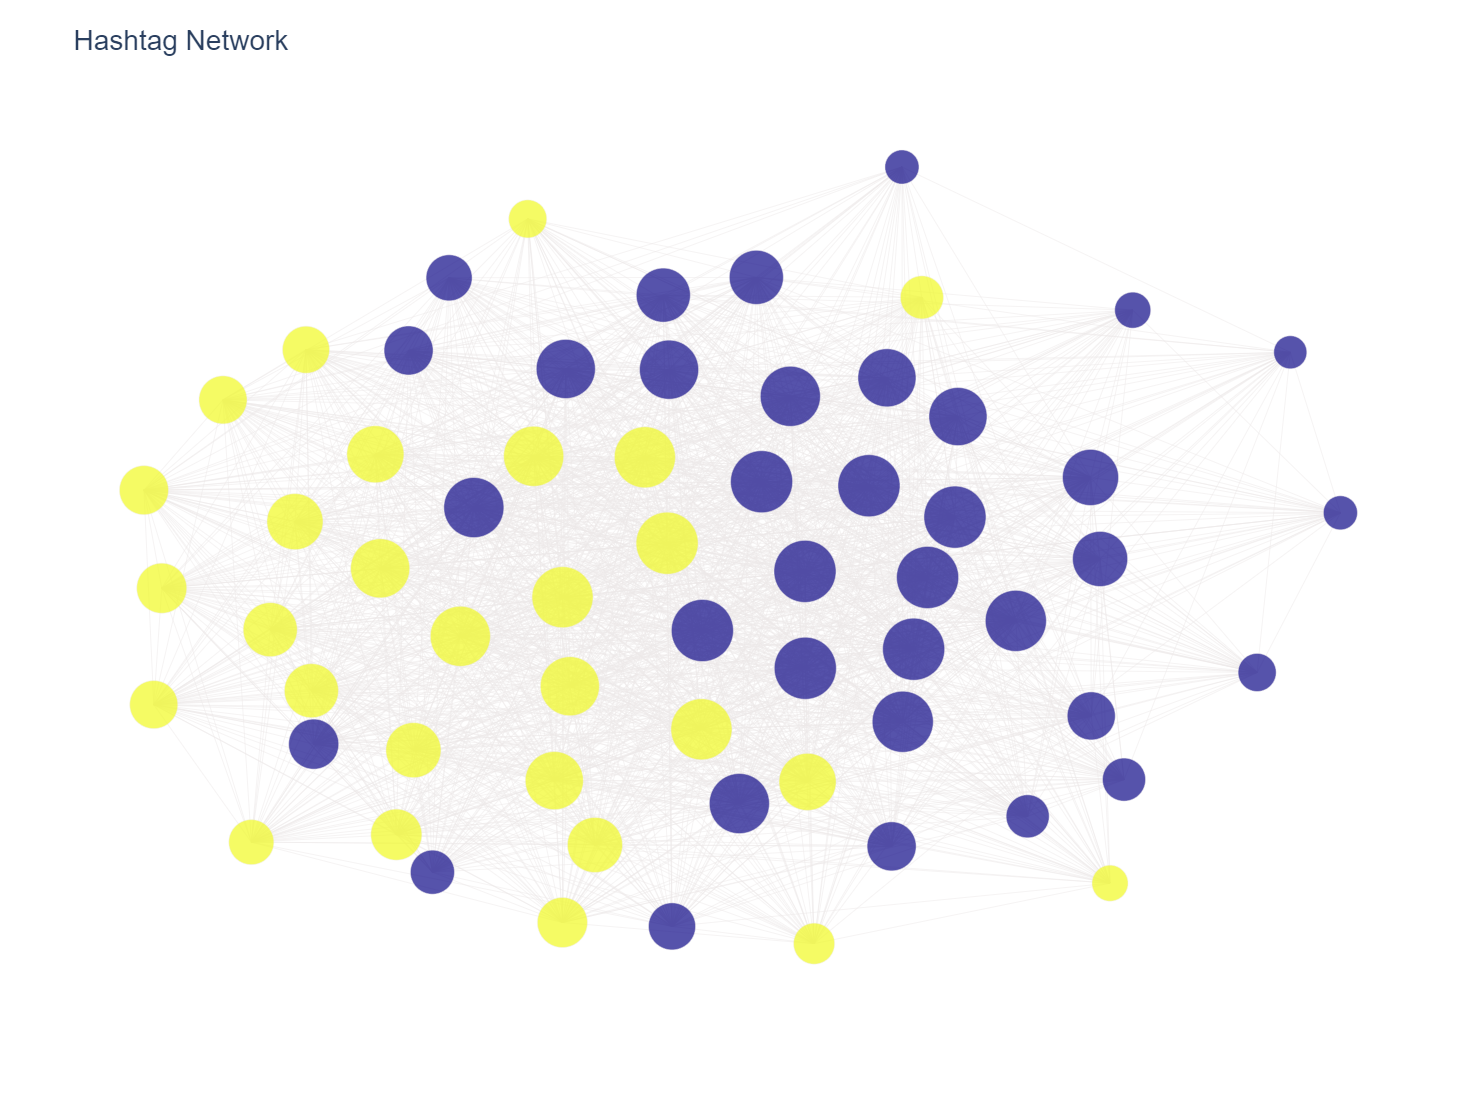

In [285]:
plotGraph(nodes_df, hashtag_graph)

![hashtag](./img/plots/hashtag_network.png)

In the above plot that gives the view about the network of the hashtags, the color identifies the community and size denotes the adjacency values of each node. We observe that almost all nodes have the same adjacency values indicating that people used the common hastags together. This is possibliy indicating that the users have used common hashtags to increase their reach.